# HVM LAOS: Large-Amplitude Oscillatory Shear and Harmonic Analysis

## Introduction

This notebook demonstrates the HVM response under **Large-Amplitude Oscillatory Shear
(LAOS)** — the most demanding rheological protocol, probing the full nonlinear
viscoelastic behavior of vitrimers.

**Physical context:** Under large oscillatory strain $\gamma(t) = \gamma_0 \sin(\omega t)$,
the HVM stress response becomes nonlinear through two mechanisms:
1. **TST mechanochemical feedback**: The BER rate $k_{BER} = \nu_0 e^{-E_a/RT}
   \cosh(V_{act}\sigma_{VM}^E/RT)$ is stress-dependent, so the E-network response
   distorts from a simple ellipse as stress grows
2. **D-network shear thinning**: At large amplitudes, $\gamma_0 \omega \gg k_d^D$,
   the dissociative network enters the nonlinear Maxwell regime

The nonlinearity is quantified via **Fourier harmonics**: the stress is decomposed as
$\sigma(t) = \sum_n [\sigma'_n \cos(n\omega t) + \sigma''_n \sin(n\omega t)]$.
Only odd harmonics ($n = 1, 3, 5, \ldots$) appear for symmetric nonlinearity, and the
ratio $I_3/I_1 = |\sigma_3|/|\sigma_1|$ serves as a **nonlinearity fingerprint**.

**Lissajous figures** provide complementary insight:
- **Elastic** ($\sigma$ vs $\gamma$): Ellipse → strain stiffening/softening
- **Viscous** ($\sigma$ vs $\dot{\gamma}$): Ellipse → shear thinning/thickening

> **Handbook:** See [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) for the
> tensorial formulation that enables normal stress predictions ($N_1$). See
> [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) for LAOS
> as the final validation step in the multi-protocol fitting strategy.

## Workflow

1. Load LAOS data (strain, stress waveforms)
2. Lissajous figure construction (data)
3. HVM LAOS simulation (3-network ODE integration)
4. Model vs data comparison
5. Fourier harmonic analysis ($I_3/I_1$ nonlinearity ratio)
6. Linear vs nonlinear regime comparison
7. Normal stress differences and network decomposition

## Prerequisites

- **Notebook 01** (SAOS) — HVM architecture, parameter meanings, TST kinetics
- **Notebook 06** (LAOS basics) — Lissajous figures, harmonic analysis, $I_3/I_1$ ratio

## Estimated Runtime

- ~3 min (LAOS simulation + harmonic analysis in FAST_MODE)

**IMPORTANT NOTE**: LAOS data is from a thixotropic yield stress fluid (PNAS 2022),
not a vitrimer. We use it as a proxy to demonstrate the HVM LAOS workflow.

## 1. Setup

In [1]:
# JAX float64 configuration (MUST come before any JAX import)
from rheojax.core.jax_config import safe_import_jax, verify_float64

jax, jnp = safe_import_jax()
verify_float64()

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Add examples directory to path for utility modules
sys.path.insert(0, str(Path("..").resolve()))

from utils.hvm_data import check_data_quality, load_pnas_laos
from utils.hvm_fit import FAST_MODE, get_output_dir, save_figure, save_results

from rheojax.models import HVMLocal

%matplotlib inline

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Fast mode: {FAST_MODE}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3
JAX devices: [CpuDevice(id=0)]
Fast mode: True


## 2. Load LAOS Data

Loading PNAS Digital Rheometer Twin LAOS data at ω=1.0 rad/s with large strain amplitude (index 5).

In [2]:
# Load LAOS data
omega_val = 1.0  # rad/s
strain_amp_idx = 5  # Large amplitude
max_points = 500 if FAST_MODE else 1000

time, strain, stress = load_pnas_laos(
    omega=omega_val,
    strain_amplitude_index=strain_amp_idx,
    max_points=max_points
)

# Quality checks
check_data_quality(time, stress, f"PNAS LAOS ω={omega_val}, amp_idx={strain_amp_idx}")

# Estimate parameters from data
gamma_0 = np.max(np.abs(strain))
stress_amplitude = np.max(np.abs(stress))
period = 2 * np.pi / omega_val
n_cycles_data = (time[-1] - time[0]) / period

print(f"\nData characteristics:")
print(f"  Strain amplitude: γ₀ = {gamma_0:.4f}")
print(f"  Stress amplitude: σ_max = {stress_amplitude:.2f} Pa")
print(f"  Angular frequency: ω = {omega_val} rad/s")
print(f"  Period: T = {period:.2f} s")
print(f"  Number of cycles: {n_cycles_data:.1f}")
print(f"  Data points: {len(time)}")

Data QC: PNAS LAOS ω=1.0, amp_idx=5
  Points: 500
  x range: [0.005268, 66]
  y range: [-17.3, 25.3]

Data characteristics:
  Strain amplitude: γ₀ = 0.5120
  Stress amplitude: σ_max = 25.30 Pa
  Angular frequency: ω = 1.0 rad/s
  Period: T = 6.28 s
  Number of cycles: 10.5
  Data points: 500


## 3. Data Exploration

### 3.1 Raw Waveform

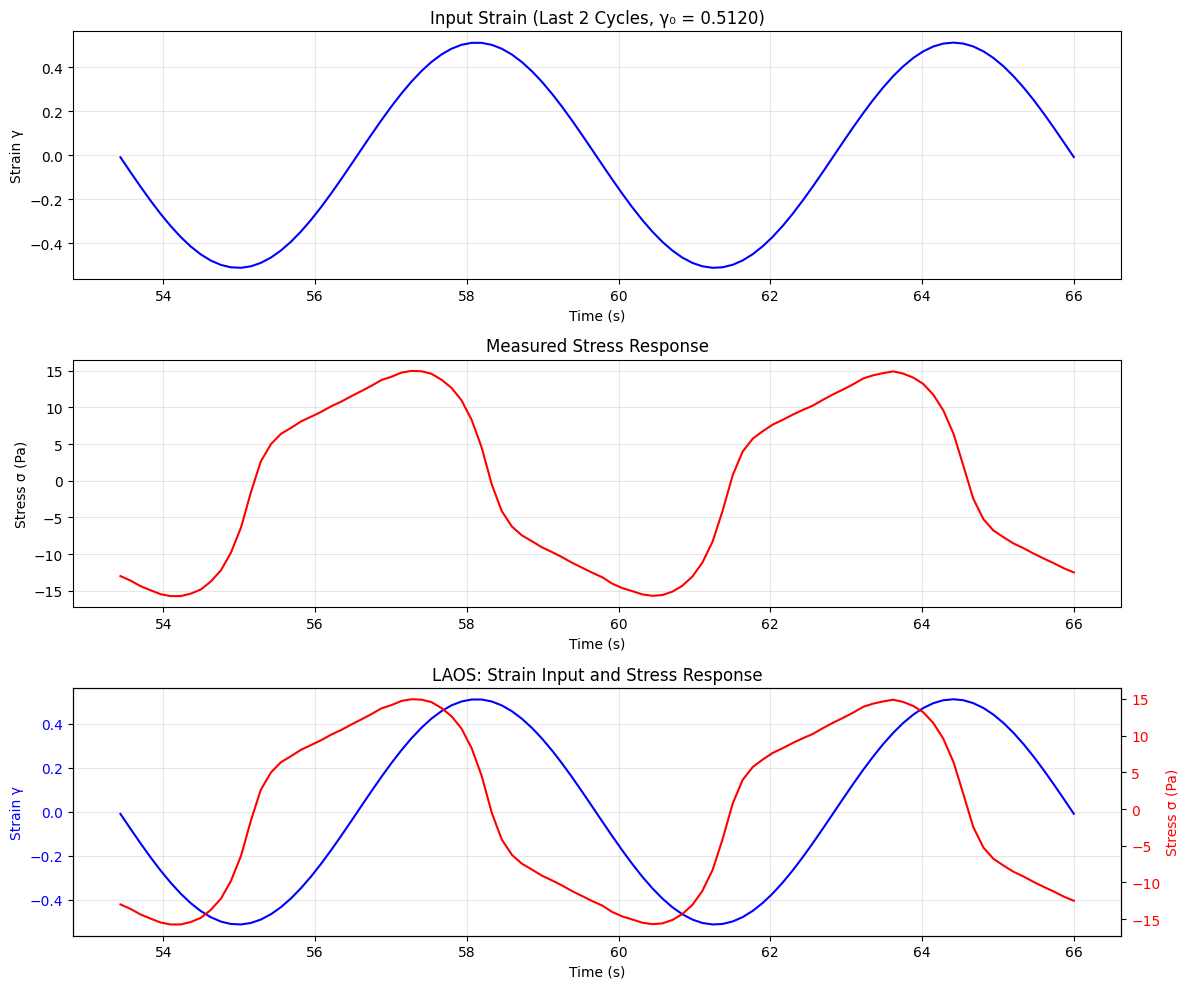

In [3]:
# Plot last 2 cycles for clarity
t_cutoff = time[-1] - 2 * period
mask_plot = time >= t_cutoff

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Strain input
ax1.plot(time[mask_plot], strain[mask_plot], 'b-', lw=1.5)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Strain γ')
ax1.set_title(f'Input Strain (Last 2 Cycles, γ₀ = {gamma_0:.4f})')
ax1.grid(True, alpha=0.3)

# Stress response
ax2.plot(time[mask_plot], stress[mask_plot], 'r-', lw=1.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Stress σ (Pa)')
ax2.set_title('Measured Stress Response')
ax2.grid(True, alpha=0.3)

# Both overlaid
ax3_twin = ax3.twinx()
ax3.plot(time[mask_plot], strain[mask_plot], 'b-', lw=1.5, label='Strain γ')
ax3_twin.plot(time[mask_plot], stress[mask_plot], 'r-', lw=1.5, label='Stress σ')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Strain γ', color='b')
ax3_twin.set_ylabel('Stress σ (Pa)', color='r')
ax3.set_title('LAOS: Strain Input and Stress Response')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='y', labelcolor='b')
ax3_twin.tick_params(axis='y', labelcolor='r')

plt.tight_layout()
display(fig)
plt.close(fig)

### 3.2 Lissajous Figures (Data)

Lissajous figures reveal nonlinear behavior:
- **Elastic (σ vs γ)**: Perfect ellipse → linear viscoelasticity; distortion → nonlinearity
- **Viscous (σ vs dγ/dt)**: Perfect ellipse → Newtonian; distortion → shear thinning/thickening

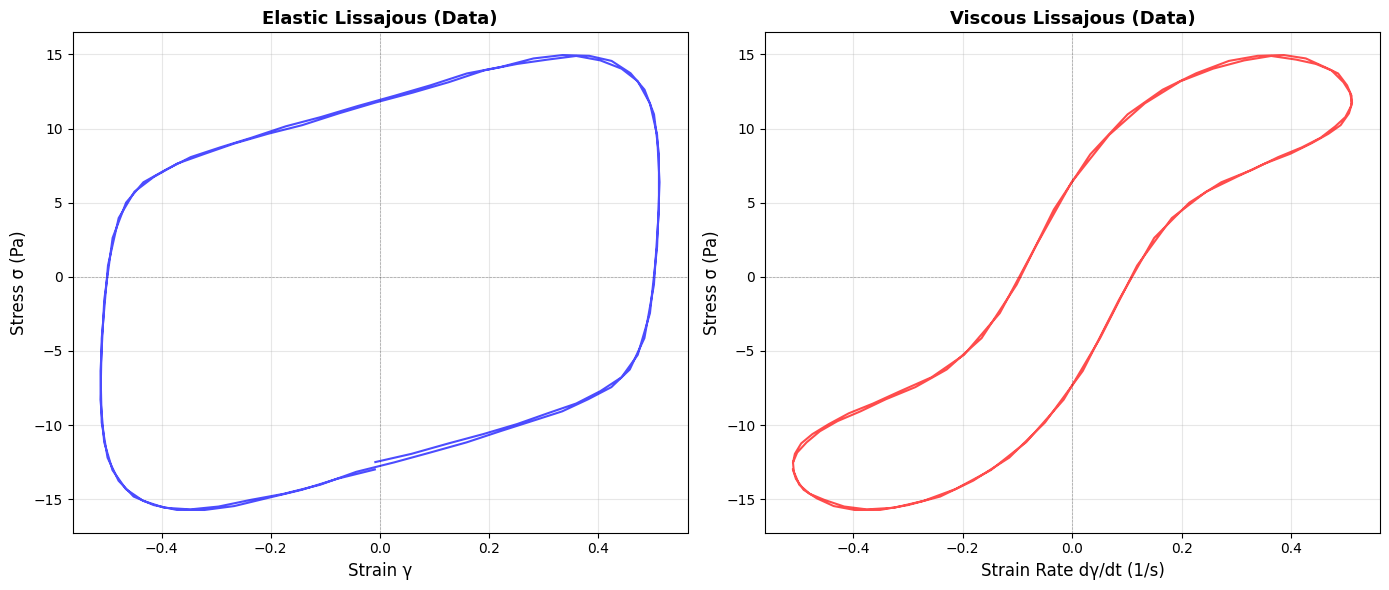

In [4]:
# Compute strain rate
gamma_dot_data = np.gradient(strain, time)

# Plot Lissajous for last 2 cycles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Elastic Lissajous (stress vs strain)
ax1.plot(strain[mask_plot], stress[mask_plot], 'b-', lw=1.5, alpha=0.7)
ax1.axhline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax1.axvline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax1.set_xlabel('Strain γ', fontsize=12)
ax1.set_ylabel('Stress σ (Pa)', fontsize=12)
ax1.set_title('Elastic Lissajous (Data)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Viscous Lissajous (stress vs strain rate)
ax2.plot(gamma_dot_data[mask_plot], stress[mask_plot], 'r-', lw=1.5, alpha=0.7)
ax2.axhline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax2.axvline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax2.set_xlabel('Strain Rate dγ/dt (1/s)', fontsize=12)
ax2.set_ylabel('Stress σ (Pa)', fontsize=12)
ax2.set_title('Viscous Lissajous (Data)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. HVM Model Setup

Initialize HVM with all three networks (permanent, exchangeable, dissociative) for LAOS simulation.

In [5]:
# Initialize HVM model
model = HVMLocal(include_dissociative=True, kinetics="stress")

# Set reasonable parameters for LAOS demonstration
# (These would normally come from SAOS or relaxation fits)
model.parameters.set_value("T", 300.0)          # Temperature (K)
model.parameters.set_value("G_P", 50.0)         # Permanent network modulus (Pa)
model.parameters.set_value("G_E", 30.0)         # Exchangeable network modulus (Pa)
model.parameters.set_value("nu_0", 1e12)        # Attempt frequency (1/s)
model.parameters.set_value("E_a", 80e3)         # Activation energy (J/mol)
model.parameters.set_value("V_act", 1e-5)      # Activation volume (m³)
model.parameters.set_value("G_D", 20.0)         # Dissociative network modulus (Pa)
model.parameters.set_value("k_d_D", 1.0)        # Dissociative rate (1/s)

print("HVM Parameters for LAOS:")
print(model.parameters)

HVM Parameters for LAOS:


## 5. LAOS Simulation

Simulate LAOS using HVM model with the same strain amplitude and frequency as the data.

In [6]:
# Simulation parameters
n_cycles_sim = 5 if FAST_MODE else 10  # Need enough cycles for steady state
n_points_sim = 1000 if FAST_MODE else 2000
t_end = n_cycles_sim * period
t_sim = np.linspace(0.01, t_end, n_points_sim)

print(f"Running LAOS simulation with:")
print(f"  γ₀ = {gamma_0:.4f}")
print(f"  ω = {omega_val} rad/s")
print(f"  Cycles: {n_cycles_sim}")
print(f"  Points: {n_points_sim}")

# Run LAOS simulation
laos_result = model.simulate_laos(
    t=t_sim,
    gamma_0=gamma_0,
    omega=omega_val
)

print(f"\nSimulation complete. Result keys: {list(laos_result.keys())}")
print(f"Stress range: [{laos_result['stress'].min():.2f}, {laos_result['stress'].max():.2f}] Pa")

Running LAOS simulation with:
  γ₀ = 0.5120
  ω = 1.0 rad/s
  Cycles: 5
  Points: 1000



Simulation complete. Result keys: ['time', 'strain', 'stress', 'gamma_dot', 'N1', 'mu_E_xy', 'mu_E_nat_xy', 'mu_D_xy', 'damage']
Stress range: [-47.17, 45.86] Pa


## 6. Model vs Data Comparison

### 6.1 Waveform Comparison

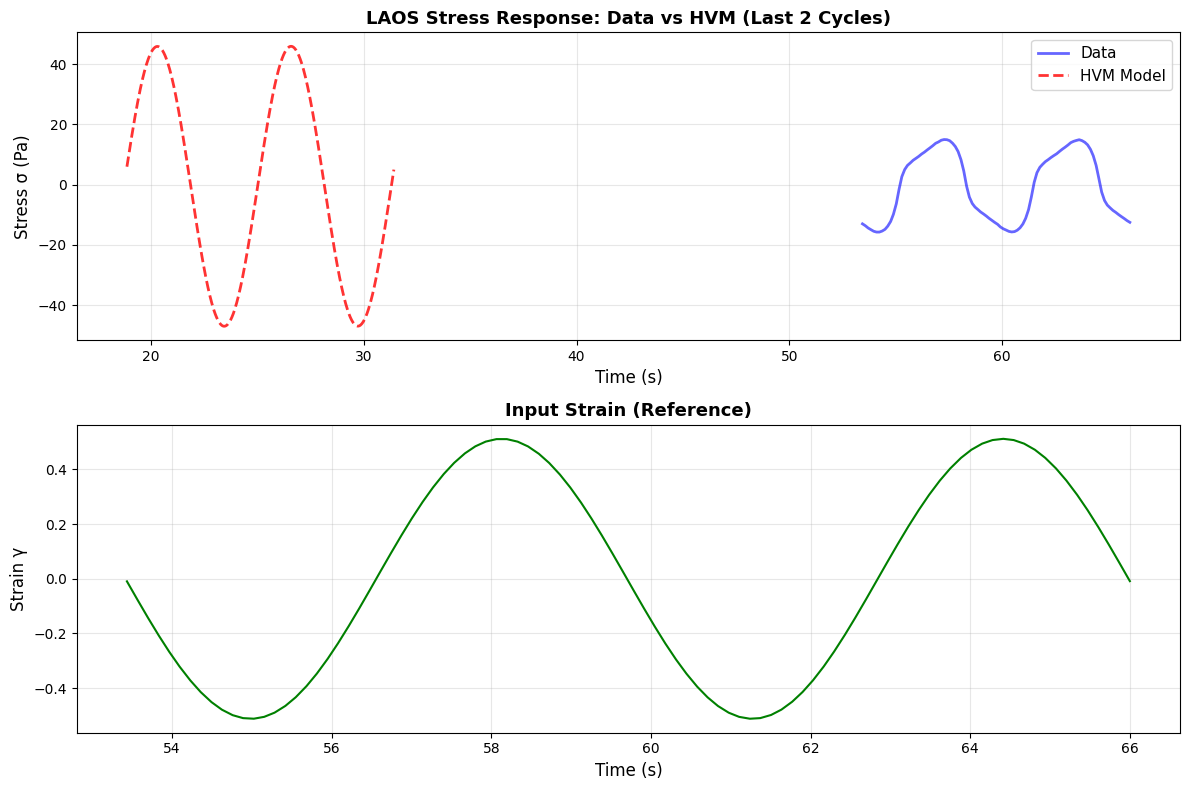

In [7]:
# Extract last 2 cycles from simulation
t_sim_cutoff = t_sim[-1] - 2 * period
mask_sim = laos_result['time'] >= t_sim_cutoff

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Stress waveform comparison
ax1.plot(time[mask_plot], stress[mask_plot], 'b-', lw=2, alpha=0.6, label='Data')
ax1.plot(
    laos_result['time'][mask_sim],
    laos_result['stress'][mask_sim],
    'r--', lw=2, alpha=0.8, label='HVM Model'
)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Stress σ (Pa)', fontsize=12)
ax1.set_title('LAOS Stress Response: Data vs HVM (Last 2 Cycles)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Strain for reference
ax2.plot(time[mask_plot], strain[mask_plot], 'g-', lw=1.5)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Strain γ', fontsize=12)
ax2.set_title('Input Strain (Reference)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

### 6.2 Lissajous Comparison

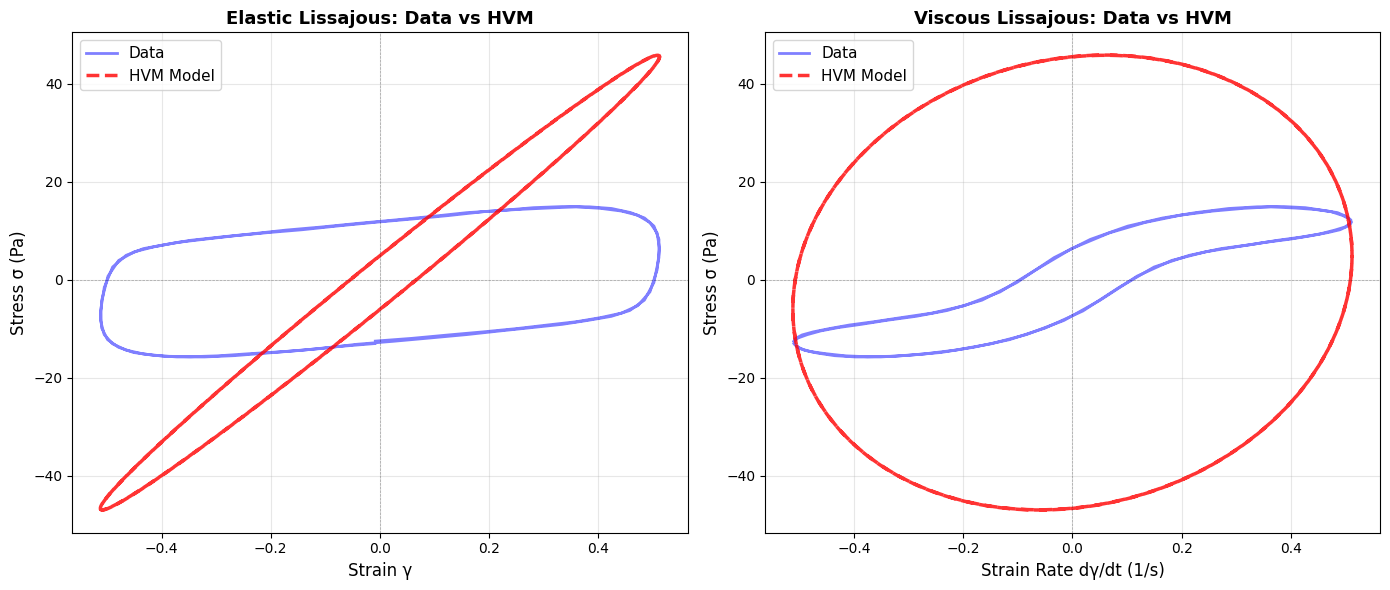

In [8]:
# Compute strain rate from simulation
gamma_dot_sim = np.gradient(laos_result['strain'], laos_result['time'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Elastic Lissajous comparison
ax1.plot(strain[mask_plot], stress[mask_plot], 'b-', lw=2, alpha=0.5, label='Data')
ax1.plot(
    laos_result['strain'][mask_sim],
    laos_result['stress'][mask_sim],
    'r--', lw=2.5, alpha=0.8, label='HVM Model'
)
ax1.axhline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax1.axvline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax1.set_xlabel('Strain γ', fontsize=12)
ax1.set_ylabel('Stress σ (Pa)', fontsize=12)
ax1.set_title('Elastic Lissajous: Data vs HVM', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Viscous Lissajous comparison
ax2.plot(gamma_dot_data[mask_plot], stress[mask_plot], 'b-', lw=2, alpha=0.5, label='Data')
ax2.plot(
    gamma_dot_sim[mask_sim],
    laos_result['stress'][mask_sim],
    'r--', lw=2.5, alpha=0.8, label='HVM Model'
)
ax2.axhline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax2.axvline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax2.set_xlabel('Strain Rate dγ/dt (1/s)', fontsize=12)
ax2.set_ylabel('Stress σ (Pa)', fontsize=12)
ax2.set_title('Viscous Lissajous: Data vs HVM', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Harmonic Analysis

Fourier decomposition of the stress signal quantifies nonlinearity:
- **σ(t) = Σₙ [σ'ₙ·cos(nωt) + σ''ₙ·sin(nωt)]**
- **n=1**: Fundamental (linear response)
- **n≥3**: Higher harmonics (odd only for symmetric nonlinearity)

In [9]:
# Extract harmonics from HVM simulation
n_harmonics = 7 if FAST_MODE else 11
harmonics = model.extract_laos_harmonics(laos_result, n_harmonics=n_harmonics)

print(f"Extracted {len(harmonics['harmonic_index'])} harmonics")
print(f"\nHarmonic amplitudes:")
for i, amp in zip(harmonics['harmonic_index'], harmonics['sigma_harmonics']):
    print(f"  n={i}: |σ_{i}| = {amp:.4f} Pa")

# Calculate nonlinearity metrics
I3_I1 = harmonics['sigma_harmonics'][2] / harmonics['sigma_harmonics'][0]  # σ₃/σ₁
print(f"\nNonlinearity ratio I₃/I₁ = {I3_I1:.4f}")

Extracted 7 harmonics

Harmonic amplitudes:
  n=1: |σ_1| = 46.3635 Pa
  n=3: |σ_3| = 0.0291 Pa
  n=5: |σ_5| = 0.0164 Pa
  n=7: |σ_7| = 0.0116 Pa
  n=9: |σ_9| = 0.0089 Pa
  n=11: |σ_11| = 0.0073 Pa
  n=13: |σ_13| = 0.0062 Pa

Nonlinearity ratio I₃/I₁ = 0.0004


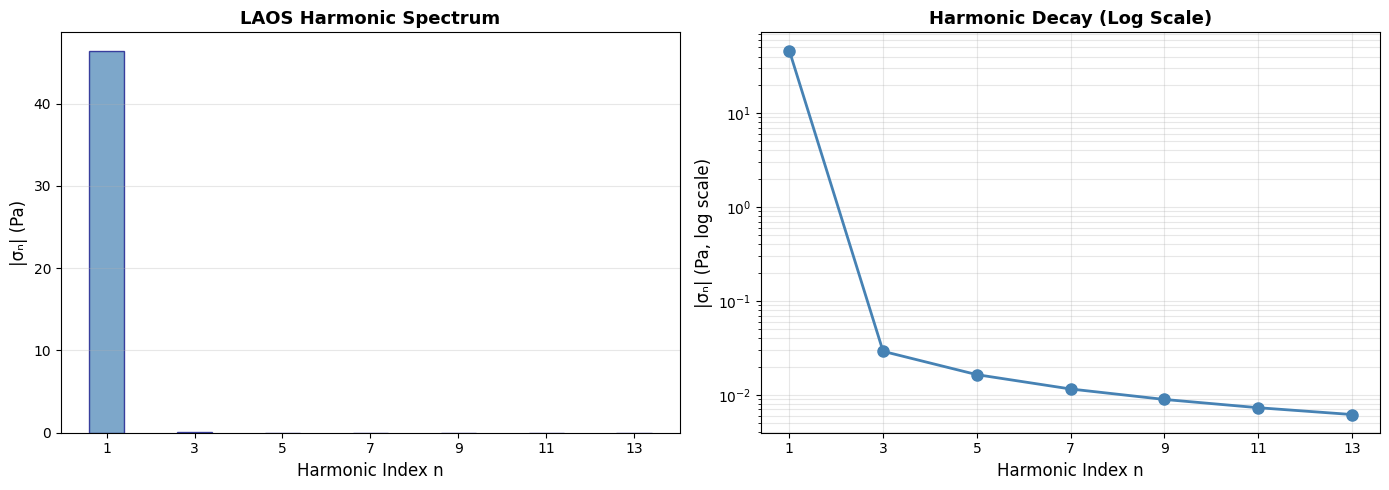

In [10]:
# Plot harmonic spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Harmonic amplitudes (bar chart)
ax1.bar(
    harmonics['harmonic_index'],
    harmonics['sigma_harmonics'],
    color='steelblue',
    edgecolor='navy',
    alpha=0.7
)
ax1.set_xlabel('Harmonic Index n', fontsize=12)
ax1.set_ylabel('|σₙ| (Pa)', fontsize=12)
ax1.set_title('LAOS Harmonic Spectrum', fontsize=13, fontweight='bold')
ax1.set_xticks(harmonics['harmonic_index'])
ax1.grid(True, alpha=0.3, axis='y')

# Log scale for clarity
ax2.semilogy(
    harmonics['harmonic_index'],
    harmonics['sigma_harmonics'],
    'o-',
    color='steelblue',
    markersize=8,
    lw=2
)
ax2.set_xlabel('Harmonic Index n', fontsize=12)
ax2.set_ylabel('|σₙ| (Pa, log scale)', fontsize=12)
ax2.set_title('Harmonic Decay (Log Scale)', fontsize=13, fontweight='bold')
ax2.set_xticks(harmonics['harmonic_index'])
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Linear vs Nonlinear Regime Comparison

Demonstrate amplitude dependence by comparing:
- **Small γ₀** (linear regime): Elliptical Lissajous, only fundamental harmonic
- **Large γ₀** (nonlinear regime): Distorted Lissajous, higher harmonics present

In [11]:
# Small amplitude (linear regime)
gamma_0_small = 0.01
n_cycles_compare = 3
n_points_compare = 500 if FAST_MODE else 1000
t_compare = np.linspace(0.01, n_cycles_compare * period, n_points_compare)

print(f"Running linear regime LAOS (γ₀ = {gamma_0_small})...")
laos_linear = model.simulate_laos(t_compare, gamma_0=gamma_0_small, omega=omega_val)

print(f"Running nonlinear regime LAOS (γ₀ = {gamma_0})...")
laos_nonlinear = model.simulate_laos(t_compare, gamma_0=gamma_0, omega=omega_val)

# Extract harmonics
harm_linear = model.extract_laos_harmonics(laos_linear, n_harmonics=n_harmonics)
harm_nonlinear = model.extract_laos_harmonics(laos_nonlinear, n_harmonics=n_harmonics)

print("\nLinear regime:")
print(f"  I₃/I₁ = {harm_linear['sigma_harmonics'][2] / harm_linear['sigma_harmonics'][0]:.6f}")
print("\nNonlinear regime:")
print(f"  I₃/I₁ = {harm_nonlinear['sigma_harmonics'][2] / harm_nonlinear['sigma_harmonics'][0]:.6f}")

Running linear regime LAOS (γ₀ = 0.01)...


Running nonlinear regime LAOS (γ₀ = 0.51199)...



Linear regime:
  I₃/I₁ = 0.000279

Nonlinear regime:
  I₃/I₁ = 0.000280


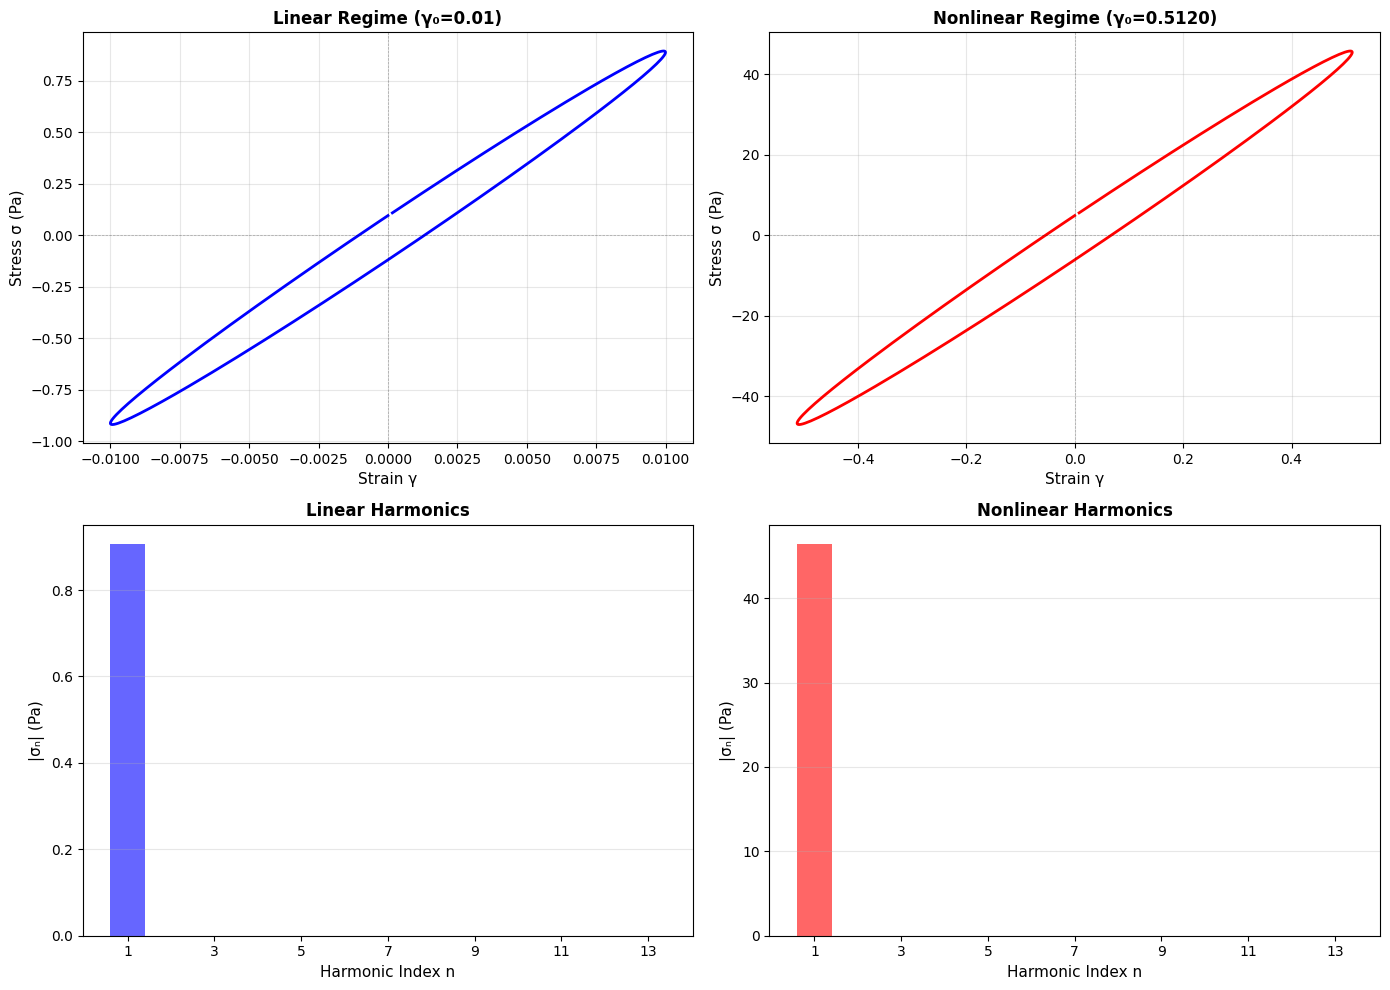

In [12]:
# Plot comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Extract last cycle for clean visualization
t_cutoff_compare = t_compare[-1] - period
mask_lin = laos_linear['time'] >= t_cutoff_compare
mask_nonlin = laos_nonlinear['time'] >= t_cutoff_compare

# Linear Lissajous (elastic)
ax1.plot(
    laos_linear['strain'][mask_lin],
    laos_linear['stress'][mask_lin],
    'b-', lw=2
)
ax1.axhline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax1.axvline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax1.set_xlabel('Strain γ', fontsize=11)
ax1.set_ylabel('Stress σ (Pa)', fontsize=11)
ax1.set_title(f'Linear Regime (γ₀={gamma_0_small})', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Nonlinear Lissajous (elastic)
ax2.plot(
    laos_nonlinear['strain'][mask_nonlin],
    laos_nonlinear['stress'][mask_nonlin],
    'r-', lw=2
)
ax2.axhline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax2.axvline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
ax2.set_xlabel('Strain γ', fontsize=11)
ax2.set_ylabel('Stress σ (Pa)', fontsize=11)
ax2.set_title(f'Nonlinear Regime (γ₀={gamma_0:.4f})', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Linear harmonics
ax3.bar(
    harm_linear['harmonic_index'],
    harm_linear['sigma_harmonics'],
    color='blue',
    alpha=0.6
)
ax3.set_xlabel('Harmonic Index n', fontsize=11)
ax3.set_ylabel('|σₙ| (Pa)', fontsize=11)
ax3.set_title('Linear Harmonics', fontsize=12, fontweight='bold')
ax3.set_xticks(harm_linear['harmonic_index'])
ax3.grid(True, alpha=0.3, axis='y')

# Nonlinear harmonics
ax4.bar(
    harm_nonlinear['harmonic_index'],
    harm_nonlinear['sigma_harmonics'],
    color='red',
    alpha=0.6
)
ax4.set_xlabel('Harmonic Index n', fontsize=11)
ax4.set_ylabel('|σₙ| (Pa)', fontsize=11)
ax4.set_title('Nonlinear Harmonics', fontsize=12, fontweight='bold')
ax4.set_xticks(harm_nonlinear['harmonic_index'])
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
display(fig)
plt.close(fig)

## 9. Normal Stress Differences

HVM predicts normal stress differences from the permanent and exchangeable networks:
- **N₁ = σ₁₁ - σ₂₂**: First normal stress difference (rod-climbing effect)
- **N₂ = σ₂₂ - σ₃₃**: Second normal stress difference (usually smaller)

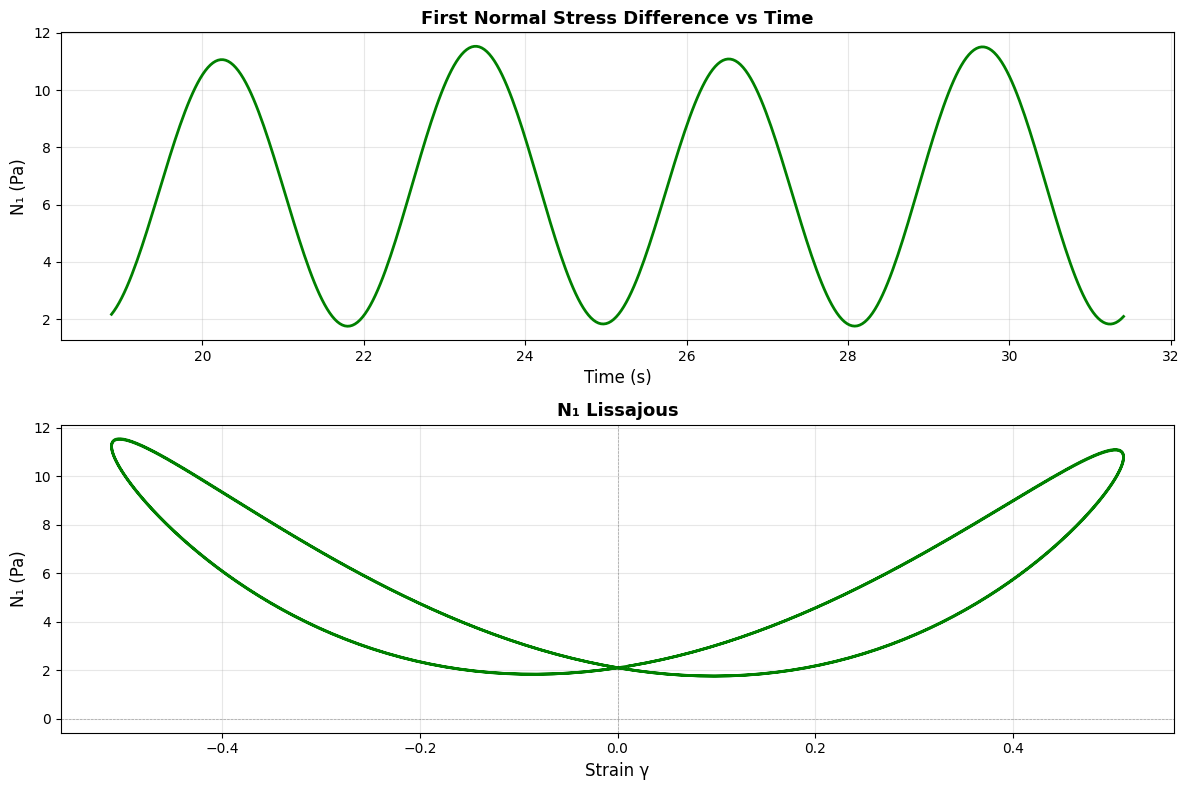


Normal stress statistics (last 2 cycles):
  N₁ mean: 6.5461 Pa
  N₁ amplitude: 4.8887 Pa


In [13]:
# Extract normal stress components from LAOS result
if 'N1' in laos_result:
    N1_laos = laos_result['N1']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # N1 time series (last 2 cycles)
    ax1.plot(
        laos_result['time'][mask_sim],
        N1_laos[mask_sim],
        'g-', lw=2
    )
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('N₁ (Pa)', fontsize=12)
    ax1.set_title('First Normal Stress Difference vs Time', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # N1 vs strain (Lissajous)
    ax2.plot(
        laos_result['strain'][mask_sim],
        N1_laos[mask_sim],
        'g-', lw=2
    )
    ax2.axhline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
    ax2.axvline(0, color='k', linestyle='--', lw=0.5, alpha=0.3)
    ax2.set_xlabel('Strain γ', fontsize=12)
    ax2.set_ylabel('N₁ (Pa)', fontsize=12)
    ax2.set_title('N₁ Lissajous', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    display(fig)
    plt.close(fig)
    
    print(f"\nNormal stress statistics (last 2 cycles):")
    print(f"  N₁ mean: {N1_laos[mask_sim].mean():.4f} Pa")
    print(f"  N₁ amplitude: {(N1_laos[mask_sim].max() - N1_laos[mask_sim].min())/2:.4f} Pa")
else:
    print("Normal stress differences not available in LAOS result.")

## 10. Network Contributions

Decompose total stress into contributions from each network.

In [14]:
# Check if network stresses are available
if 'sigma_P' in laos_result and 'sigma_E' in laos_result and 'sigma_D' in laos_result:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Time series (last 2 cycles)
    ax1.plot(
        laos_result['time'][mask_sim],
        laos_result['sigma_P'][mask_sim],
        'b-', lw=1.5, label='σ_P (Permanent)', alpha=0.7
    )
    ax1.plot(
        laos_result['time'][mask_sim],
        laos_result['sigma_E'][mask_sim],
        'g-', lw=1.5, label='σ_E (Exchangeable)', alpha=0.7
    )
    ax1.plot(
        laos_result['time'][mask_sim],
        laos_result['sigma_D'][mask_sim],
        'r-', lw=1.5, label='σ_D (Dissociative)', alpha=0.7
    )
    ax1.plot(
        laos_result['time'][mask_sim],
        laos_result['stress'][mask_sim],
        'k--', lw=2, label='σ_total', alpha=0.9
    )
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Stress (Pa)', fontsize=12)
    ax1.set_title('Network Stress Contributions vs Time', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Relative contributions (pie chart at peak strain)
    idx_peak = np.argmax(np.abs(laos_result['strain'][mask_sim]))
    idx_global = np.where(mask_sim)[0][idx_peak]
    
    contributions = [
        np.abs(laos_result['sigma_P'][idx_global]),
        np.abs(laos_result['sigma_E'][idx_global]),
        np.abs(laos_result['sigma_D'][idx_global])
    ]
    labels = ['Permanent', 'Exchangeable', 'Dissociative']
    colors = ['blue', 'green', 'red']
    
    ax2.pie(
        contributions,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 11}
    )
    ax2.set_title(
        f'Network Contributions at Peak Strain (γ={laos_result["strain"][idx_global]:.4f})',
        fontsize=13,
        fontweight='bold'
    )
    
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Network stress decomposition not available in LAOS result.")

Network stress decomposition not available in LAOS result.


## 11. Save Results

In [15]:
# Save results
output_dir = get_output_dir("laos")

# Save model parameters
save_results(output_dir, model)

print(f"\n{'='*60}")
print("Results saved to:")
print(f"  {output_dir}")
print(f"{'='*60}")


Results saved to:
  /Users/b80985/Projects/rheojax/examples/outputs/hvm/laos


## Summary

This notebook demonstrated:

1. **LAOS Data**: Loaded large-amplitude oscillatory shear data from PNAS Digital Rheometer Twin
2. **Lissajous Analysis**: Visualized nonlinear behavior in elastic and viscous representations
3. **HVM Simulation**: Generated LAOS response from 3-network vitrimer model
4. **Harmonic Decomposition**: Quantified nonlinearity via Fourier analysis ($I_3/I_1$ ratio)
5. **Amplitude Dependence**: Compared linear (elliptical) vs nonlinear (distorted) regimes
6. **Normal Stresses**: Extracted $N_1$ from tensorial HVM formulation
7. **Network Contributions**: Decomposed total stress into P, E, D components

**Key Insights**:
- Higher harmonics ($n \geq 3$) indicate departure from linear viscoelasticity
- Lissajous distortion reveals strain stiffening/softening and shear thinning/thickening
- HVM captures nonlinearity through TST stress-dependent BER kinetics
- PNAS data is from a thixotropic fluid (not vitrimer), used as a proxy for workflow demonstration

## Further Reading

**Handbook Documentation:**
- [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) — Tensorial formulation, TST kinetics, normal stress predictions
- [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) — LAOS as final validation step, parameter identifiability across protocols
- [HVM Protocol Derivations](../../docs/source/models/hvm/hvm_protocols.rst) — LAOS ODE integration, steady-state cycle extraction

**References:**
1. Vernerey, F.J., Long, R. & Brighenti, R. (2017). A statistically-based continuum theory for polymers with transient networks. *J. Mech. Phys. Solids*, 107, 1-20.
2. Hyun, K. et al. (2011). A review of nonlinear oscillatory shear tests: Analysis and application of large amplitude oscillatory shear (LAOS). *Prog. Polym. Sci.*, 36, 1697-1753.
3. Ewoldt, R.H., Hosoi, A.E. & McKinley, G.H. (2008). New measures for characterizing nonlinear viscoelasticity in large amplitude oscillatory shear. *J. Rheol.*, 52, 1427-1458.

## Complete HVM Notebook Series

| # | Notebook | Protocol | Content |
|---|----------|----------|---------|
| 01 | `01_hvm_saos` | SAOS | Gateway tutorial: architecture, parameters, physics |
| 02 | `02_hvm_stress_relaxation` | Relaxation | Bi-exponential decay, permanent plateau |
| 03 | `03_hvm_startup_shear` | Startup | TST stress overshoot, rate dependence |
| 04 | `04_hvm_creep` | Creep | Compliance, delayed flow, natural-state tracking |
| 05 | `05_hvm_flow_curve` | Flow curve | Steady state, $\sigma_E \to 0$ |
| 06 | `06_hvm_laos` | LAOS | Lissajous, harmonics, nonlinear regime |
| 07 | `07_hvm_overview` | All | Model overview and factory methods |
| 08 | `08_hvm_flow_curve` | Flow curve | NLSQ + NUTS Bayesian pipeline |
| 09 | `09_hvm_creep` | Creep | NLSQ + NUTS Bayesian pipeline |
| 10 | `10_hvm_relaxation` | Relaxation | NLSQ + NUTS Bayesian pipeline |
| 11 | `11_hvm_startup` | Startup | NLSQ + NUTS Bayesian pipeline |
| 12 | `12_hvm_saos` | SAOS | NLSQ + NUTS + temperature series |
| 13 | `13_hvm_laos` | LAOS | Harmonic analysis + network decomposition |